<a href="https://colab.research.google.com/github/tozanni/Data_Science_Notebooks/blob/main/CIFAR10_CNN_wNoise_SinSolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificador CNN para CIFAR10 con ruido y aumentación de datos

En este cuaderno exploraremos los siguientes conceptos:

- Agregar ruido sintético a las imágenes para simular un dataset con ruido.
- Evaluar el clasificador original en imágenes con ruido.
- Mejorar el desempeño del clasificador mediante una aumentación de datos.


In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


Verificando la cantidad de imagenes en el dataset y su dimension, en este caso recibimos 50,000 imagenes de 32x32 x 3 canales de color.

In [ ]:
# Normalizar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Datos generales
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# Dividir validation y test
x_val = x_test[:7000]
x_test = x_test[7000:]
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


In [ ]:
# Etiquetas
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

### Introducción de ruido sintético

Generamos versiones "noisy" de nuestro training, test y validation set.


In [ ]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)


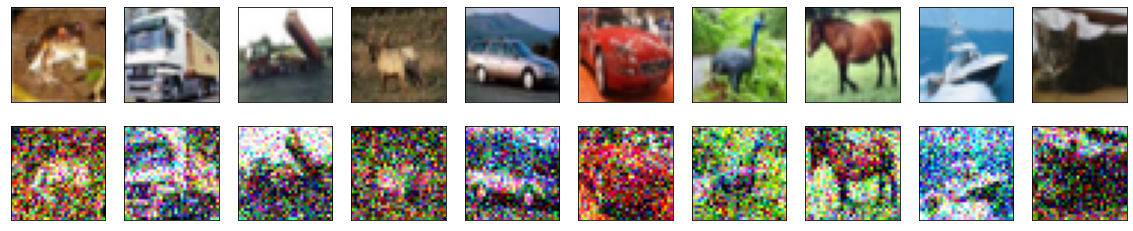

In [ ]:
# Funcion para mostrar imagen original e imagen con ruido
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

showOrigDec(x_train, x_train_noisy)

In [ ]:
# Se codifican las etiquetas como one-hot, posteriormente se utilizará la función de categorical-cross-entropy
num_classes = 10
y_train_labels = np_utils.to_categorical(y_train, num_classes)
y_test_labels = np_utils.to_categorical(y_test, num_classes)


In [ ]:
# Dividir etiquetas de validacion
y_val_labels = y_test_labels[:7000]
y_test_labels = y_test_labels[7000:]

In [ ]:
model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

El entrenamiento lo haremos con las imagenes originales, pero la validacion y pruebas con las imagenes con ruido. 

In [ ]:
history = model.fit(x_train, y_train_labels, batch_size=64, epochs=20, validation_data=(x_val_noisy, y_val_labels))

Epoch 1/20
782/782 [==============================] - 21s 11ms/step - loss: 1.7047 - accuracy: 0.4114 - val_loss: 3.8994 - val_accuracy: 0.1889
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.1724 - accuracy: 0.5818 - val_loss: 5.6646 - val_accuracy: 0.1091
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 0.9926 - accuracy: 0.6486 - val_loss: 3.6682 - val_accuracy: 0.1654
Epoch 4/20
782/782 [==============================] - 8s 11ms/step - loss: 0.8869 - accuracy: 0.6928 - val_loss: 5.1085 - val_accuracy: 0.1027
Epoch 5/20
782/782 [==============================] - 8s 11ms/step - loss: 0.8187 - accuracy: 0.7139 - val_loss: 3.2879 - val_accuracy: 0.1770
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 0.7622 - accuracy: 0.7358 - val_loss: 3.6012 - val_accuracy: 0.1791
Epoch 7/20
782/782 [==============================] - 9s 11ms/step - loss: 0.7169 - accuracy: 0.7519 - val_loss: 5.1415 - val_accuracy: 0.113

### Visualización del proceso de entrenamiento. 

Aquí puedes ver si el entrenamiento está disminuyendo la pérdida o no. En este caso ya que el validation set (noisy) no corresponde con los datos originales vamos que el modelo no consigue aprender lo suficiente para clasificar las imágenes con ruido.

En este caso, nuestro training set no es representativo de los datos esperados (noisy) y por dicha razón el entrenamiento no es idóneo.

Text(0.5, 1.0, 'Loss Curves')

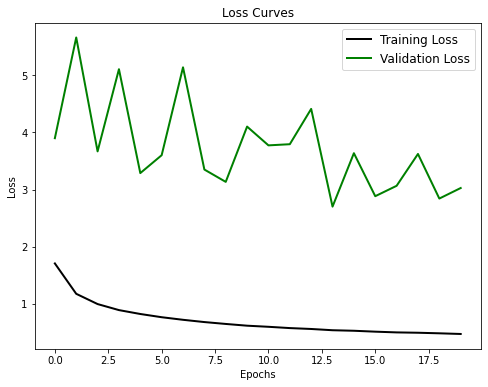

In [ ]:
# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Del mismo modo puedes observar la calidad de la predicción en el conjunto de test. Conforme avanzan las épocas, la exactitud de la predicción (Accuracy) se va incrementando. ¿Te parece que más épocas ayudarían al modelo?

Text(0.5, 1.0, 'Accuracy Curves')

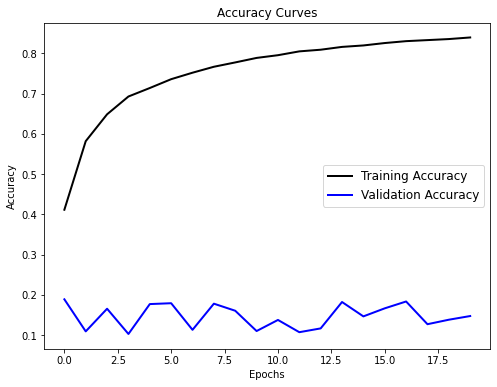

In [ ]:
# Accuracy curve
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [ ]:
# Making the Predictions
pred = model.predict(x_test_noisy)
print(pred)

# Converting the predictions into label index 
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)


[[0.05875004 0.01682143 0.1085163  ... 0.00620734 0.0593986  0.04346715]
 [0.02329609 0.05880406 0.07231639 ... 0.00240536 0.01641955 0.01244481]
 [0.00259686 0.00082855 0.02988156 ... 0.00270941 0.0082973  0.00067352]
 ...
 [0.04569187 0.01904076 0.11670738 ... 0.0018468  0.03749012 0.01321169]
 [0.00172083 0.00051455 0.04149384 ... 0.0013405  0.00333431 0.00095682]
 [0.01528412 0.00848415 0.2188538  ... 0.00772576 0.02147411 0.01586605]]
[6 6 6 ... 6 6 6]


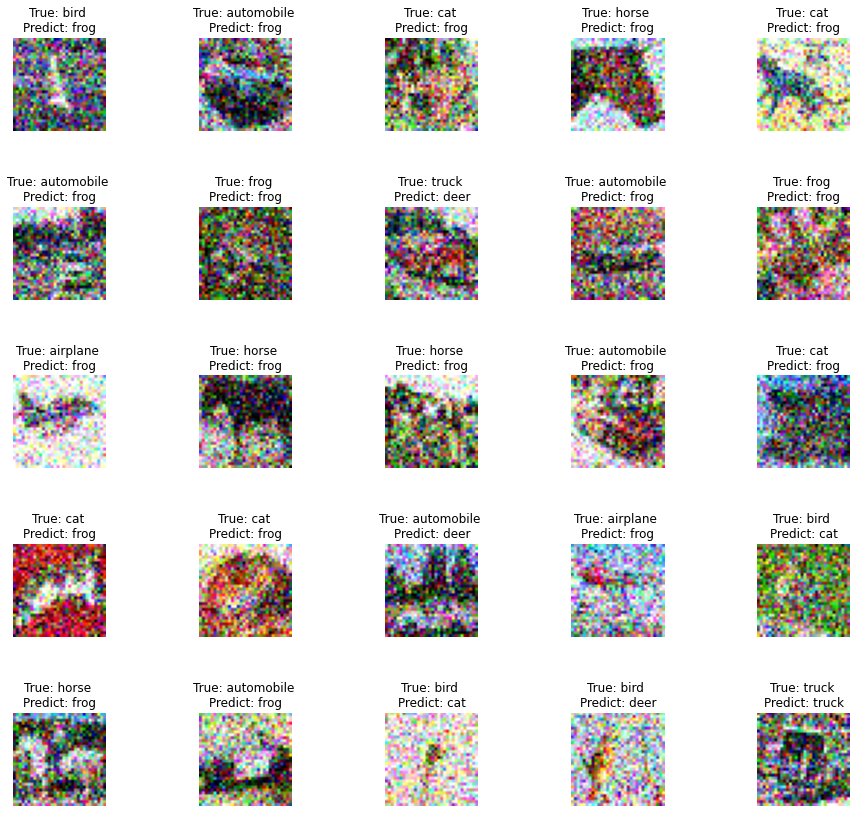

In [ ]:
# Plotting the Actual vs. Predicted results

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(x_test_noisy[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(y_test_labels[i])], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

## Evaluación de desempeño del modelo

Nota cómo al pasar imágenes con ruido a un clasificador que no está preparado para ellas, el resultado de la clasificación se degrada bastante.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

cm=confusion_matrix(y_test_labels.argmax(axis=1), pred.argmax(axis=1))
print("Classification Report:\n")
cr=classification_report(y_test_labels.argmax(axis=1), pred.argmax(axis=1), target_names=class_names)
print(cr)

Classification Report:

              precision    recall  f1-score   support

    airplane       0.35      0.06      0.10       296
  automobile       0.46      0.02      0.04       311
        bird       0.16      0.05      0.07       299
         cat       0.16      0.10      0.12       302
        deer       0.10      0.13      0.12       278
         dog       0.00      0.00      0.00       293
        frog       0.12      0.90      0.22       302
       horse       0.00      0.00      0.00       298
        ship       0.28      0.04      0.08       314
       truck       0.39      0.10      0.16       307

    accuracy                           0.14      3000
   macro avg       0.20      0.14      0.09      3000
weighted avg       0.21      0.14      0.09      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Mejora del desempeño con aumentación de datos

Para tratar de disminuir el daño ocasionado por el ruido a nuestro clasificador, una técnica que podemos utilizar es la aumentación de datos. 

En este caso, entrenaremos el clasificador en las imágenes con y sin ruido, de tal forma que lo hagamos más robusto ante este fenómeno. 

Es decir, con esta técnica estamos haciendo que nuestro clasificador aprenda a clasificar imágenes con ruido y sin ruido.

In [ ]:
x_train_aug = np.concatenate((x_train, x_train_noisy), axis=0)
y_train_aug = np.concatenate((y_train_labels, y_train_labels), axis=0)

print(x_train_aug.shape)
print(y_train_aug.shape)

(100000, 32, 32, 3)
(100000, 10)


In [ ]:
# Entrenamos el modelo con el dataset aumentado, utilizamos las imagenes con ruido para validacion

history = model.fit(x_train_aug, y_train_aug, batch_size=64, epochs=20, validation_data=(x_val_noisy, y_val_labels))


Epoch 1/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0284 - accuracy: 0.6403 - val_loss: 1.1742 - val_accuracy: 0.5794
Epoch 2/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.9241 - accuracy: 0.6768 - val_loss: 1.0982 - val_accuracy: 0.6059
Epoch 3/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8889 - accuracy: 0.6892 - val_loss: 1.0395 - val_accuracy: 0.6271
Epoch 4/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8637 - accuracy: 0.6977 - val_loss: 1.0452 - val_accuracy: 0.6290
Epoch 5/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8498 - accuracy: 0.7033 - val_loss: 1.0094 - val_accuracy: 0.6410
Epoch 6/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8278 - accuracy: 0.7106 - val_loss: 1.0088 - val_accuracy: 0.6413
Epoch 7/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8128 - accuracy: 0.7169 - val_loss: 1.0207 -

Text(0.5, 1.0, 'Loss Curves')

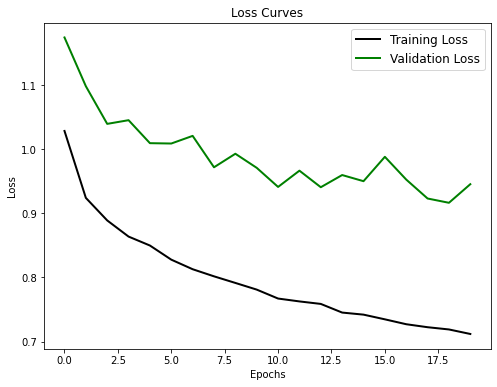

In [ ]:
# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
# Making the Predictions
pred = model.predict(x_test_noisy)
print(pred)

# Converting the predictions into label index 
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)

[[1.3556658e-01 4.7086296e-03 3.3136332e-01 ... 2.6699649e-02
  1.9847441e-01 7.3009753e-03]
 [3.9819056e-06 9.9817252e-01 1.3762835e-05 ... 3.0909254e-07
  2.6091608e-05 1.7512618e-03]
 [1.7117137e-04 8.0004113e-04 2.8504619e-02 ... 7.1697379e-03
  4.2397998e-05 2.7944800e-04]
 ...
 [8.1319467e-06 3.5809364e-06 6.1421725e-03 ... 1.9100478e-02
  9.2162023e-05 6.7668683e-05]
 [1.6848695e-02 7.1714246e-01 3.9422039e-02 ... 1.2021430e-03
  1.4255313e-03 2.4657102e-02]
 [6.5624794e-05 2.5354115e-05 3.6163360e-04 ... 9.6632093e-01
  8.5100846e-06 2.8019464e-05]]
[2 1 5 ... 5 1 7]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

cm=confusion_matrix(y_test_labels.argmax(axis=1), pred.argmax(axis=1))
print("Classification Report:\n")
cr=classification_report(y_test_labels.argmax(axis=1), pred.argmax(axis=1), target_names=class_names)
print(cr)

Classification Report:

              precision    recall  f1-score   support

    airplane       0.73      0.68      0.71       296
  automobile       0.75      0.79      0.77       311
        bird       0.57      0.55      0.56       299
         cat       0.49      0.48      0.49       302
        deer       0.59      0.56      0.57       278
         dog       0.51      0.60      0.55       293
        frog       0.67      0.72      0.69       302
       horse       0.75      0.74      0.74       298
        ship       0.77      0.75      0.76       314
       truck       0.75      0.68      0.71       307

    accuracy                           0.66      3000
   macro avg       0.66      0.66      0.66      3000
weighted avg       0.66      0.66      0.66      3000



Este resultado muestra cómo se ha recuperado una gran parte del poder predictivo del clasificador utilizando la aumentación de datos.

Ahora tienes un clasificador capaz de procesar imágenes con un alto nivel de ruido.

Sin embargo, este modelo no te permite obtener una versión sin ruido de la imagen, para lo cual es necesario implementar un autoencoder. 

Referencia: 

https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy/notebook

